In [19]:

import os
import sys
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    roc_curve,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import uniform, randint

In [20]:
data = pd.read_csv(
    "/capstone/wildfire_prep/data/PUZZLE_PIECES/assembled_puzzle.csv"
).drop(columns="basemap_id")

print(data.shape)
print(data.columns)
data.head()

(67580, 4009)
Index(['inspection_id', 'X_0', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_3998', 'X_3999', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain', 'total_rain_three_months_prior'],
      dtype='object', length=4009)


,inspection_id,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_3998,X_3999,maj_landcover_code_x,maj_landcover_code_y,status,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain,total_rain_three_months_prior
0,1,0.054892,0.0,0.015004,0.0,0.238797,0.000466,0.0,0.055266,0.005605,...,4.261047,2.500061,304.0,557,0,100,0.28,2.18,0.19,2.65
1,2,0.024470,0.0,0.003108,0.0,0.129467,0.000687,0.0,0.034108,0.012225,...,3.457836,2.098205,304.0,304,0,101,1.46,0.08,3.19,4.73
2,3,0.271383,0.0,0.126712,0.0,0.976787,0.043854,0.0,0.528058,0.124882,...,6.486201,3.454411,303.0,303,0,101,1.46,0.08,3.19,4.73
3,4,0.097084,0.0,0.037654,0.0,0.549639,0.001046,0.0,0.240636,0.017580,...,5.209030,2.868551,39.0,304,0,100,1.46,0.08,3.19,4.73
4,5,0.041986,0.0,0.008531,0.0,0.253195,0.001353,0.0,0.036694,0.002605,...,4.251881,2.500635,304.0,304,0,101,5.14,1.67,NaN,NaN


In [21]:
mosaiks86 = data[[
        "inspection_id",
        "maj_landcover_code_x",
        "maj_landcover_code_y",
        "status",
        "structure_code",
        "current_month_rain",
        "previous_month_rain",
        "two_months_prior_rain",
    ]]

data = mosaiks86
data.columns

Index(['inspection_id', 'maj_landcover_code_x', 'maj_landcover_code_y',
       'status', 'structure_code', 'current_month_rain', 'previous_month_rain',
       'two_months_prior_rain'],
      dtype='object')

## Downsample Majority Class Approach

In [22]:
# # Outdated Downsampling Approach Cell

# # Pull out majority/minority from data
# compliant = data[data.status == 0]
# non_compliant = data[data.status == 1]

# # Downsample majority to be 3x minority's size
# n_majority_desired = len(non_compliant) * 3
# compliant_down = compliant.sample(n=n_majority_desired, random_state=42)

# # Reassemble and shuffle
# data_downsampled_maj = (
#     pd.concat([non_compliant, compliant_down])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# # Split back into X_train and y_train, downsampled
# X = data_downsampled_maj.drop("status", axis=1)
# y = data_downsampled_maj["status"]

# downsample_data_ids = X.inspection_id

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Dropping inspection_id, to prevent overfitting to this ID.
# X_train = X_train.drop(columns="inspection_id")
# # Do the same for X_test, so that the datasets align
# X_test = X_test.drop(columns="inspection_id")

# # Balance check
# print("Shapes:")
# print("  X_train:", X_train.shape)
# print("  y_train:", y_train.shape)
# print("  X_test: ", X_test.shape)
# print("  y_test: ", y_test.shape)

# print("\nTrain distribution after downsampling:")
# print(y_train.value_counts(normalize=True))

# X_train


In [23]:
X = data.drop("status", axis=1)
y = data["status"]

upsample_data_ids = X.inspection_id

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train = pd.concat([X_train, y_train], axis=1)

majority = train[train.status == 0]
minority = train[train.status == 1]

n_majority_desired = len(minority) * 3
majority_downsampled = majority.sample(
    n=n_majority_desired, replace=False, random_state=42
)

train_balanced = (
    pd.concat([majority_downsampled, minority])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]

X_test = X_test.drop(columns="inspection_id")

print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", int(len(majority) * 3))

print("Shapes:")
print(" Downsampled X_train:", X_train.shape)
print(" Downsampled y_train:", y_train.shape)
print(" Downsampled X_test: ", X_test.shape)
print(" Downsampled y_test: ", y_test.shape)

print("\nTrain distribution after downsampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (53730, 8)
Shape of non-compliant: (334, 8)
N_minority desired: 161190
Shapes:
 Downsampled X_train: (1336, 6)
 Downsampled y_train: (1336,)
 Downsampled X_test:  (13516, 6)
 Downsampled y_test:  (13516,)

Train distribution after downsampling:
status
0    0.75
1    0.25
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain
0,303.0,582,102,NaN,1.09,0.05
1,581.0,304,102,0.01,0.51,0.92
2,303.0,582,102,0.01,0.02,NaN
3,556.0,556,101,0.03,NaN,NaN
4,582.0,582,102,0.34,0.45,0.07
...,...,...,...,...,...,...
1331,581.0,304,102,0.19,1.95,0.22
1332,581.0,303,100,NaN,NaN,0.01
1333,556.0,581,104,NaN,NaN,NaN
1334,582.0,303,102,0.06,1.88,0.16


## Upsample Minority Class Approach


In [24]:
# # Outdated Upsampling Approach Cell

# # Pull out majority/minority from data
# compliant = data[data.status == 0]
# non_compliant = data[data.status == 1]

# # Upsample minority to match majority’s size
# n_minority_desired = int(len(compliant) / 3)

# non_compliant_upsampled = non_compliant.sample(
#     n=n_minority_desired, replace=True, random_state=42
# )

# # Reassemble and shuffle train set
# data_upsampled_min = (
#     pd.concat([compliant, non_compliant_upsampled])
#     .sample(frac=1, random_state=42)
#     .reset_index(drop=True)
# )

# # Split back into X_train y_train, upsampled
# X = data_upsampled_min.drop("status", axis=1)
# y = data_upsampled_min["status"]

# # Save inspection_ids from the data, in case we need them later
# upsample_data_ids = X.inspection_id

# # split data, as usual. 20% test data split.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=42
# )

# # Dropping inspection_id, to prevent overfitting to this ID.
# X_train = X_train.drop(columns="inspection_id")
# # Do the same for X_test, so that the datasets align
# X_test = X_test.drop(columns="inspection_id")

# # Check majority/minority sizes
# print(f"Shape of compliant:", compliant.shape)
# print(f"Shape of non-compliant:", non_compliant.shape)

# print(f"N_minority desired:", int(len(compliant) / 3))
# print(f"Shape of non-compliant upsampled:", non_compliant_upsampled.shape)
# print(f"Shape of upsampled training data:", data_upsampled_min.shape)

# print("Shapes:")
# print(" Upsampled X_train:", X_train.shape)
# print(" Upsampled y_train:", y_train.shape)
# print(" Upsampled X_test: ", X_test.shape)
# print(" Upsampled y_test: ", y_test.shape)

# print("\nTrain distribution after up-sampling:")
# print(y_train.value_counts(normalize=True))

# X_train


In [25]:
X = data.drop("status", axis=1)
y = data["status"]

# Save inspection_ids from the data, in case we need them later
upsample_data_ids = X.inspection_id

# split data, as usual. 20% test data split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, stratify=y, random_state=42 # trying 50% test/train split, instead of 20%
)

# Recombine just the train fold
train = pd.concat([X_train, y_train], axis=1)

# Up-sample the minority inside train
majority = train[train.status == 0]
minority = train[train.status == 1]
n_min = int(len(majority) / 3)

minority_upsampled = minority.sample(n=n_min, replace=True, random_state=42)

train_balanced = (
    pd.concat([majority, minority_upsampled])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

X_train = train_balanced.drop("status", axis=1).drop(columns="inspection_id")
y_train = train_balanced["status"]
X_test = X_test.drop(columns="inspection_id")

# Check majority/minority sizes
print(f"Shape of compliant:", majority.shape)
print(f"Shape of non-compliant:", minority.shape)

print(f"N_minority desired:", n_min)

print("Shapes:")
print(" Upsampled X_train:", X_train.shape)
print(" Upsampled y_train:", y_train.shape)
print(" Upsampled X_test: ", X_test.shape)
print(" Upsampled y_test: ", y_test.shape)

print("\nTrain distribution after upsampling:")
print(y_train.value_counts(normalize=True))

X_train


Shape of compliant: (33581, 8)
Shape of non-compliant: (209, 8)
N_minority desired: 11193
Shapes:
 Upsampled X_train: (44774, 6)
 Upsampled y_train: (44774,)
 Upsampled X_test:  (33790, 6)
 Upsampled y_test:  (33790,)

Train distribution after upsampling:
status
0    0.750011
1    0.249989
Name: proportion, dtype: float64


,maj_landcover_code_x,maj_landcover_code_y,structure_code,current_month_rain,previous_month_rain,two_months_prior_rain
0,581.0,581,102,0.02,0.04,NaN
1,582.0,582,111,0.01,0.51,0.92
2,583.0,583,102,0.01,0.51,0.92
3,303.0,556,114,0.21,0.12,0.09
4,304.0,581,100,0.08,NaN,NaN
...,...,...,...,...,...,...
44769,582.0,556,101,0.01,0.51,0.92
44770,581.0,581,102,0.14,0.30,0.02
44771,581.0,581,102,NaN,NaN,NaN
44772,582.0,304,101,0.50,1.13,0.03


# XGBoost Classifier

Length of y_pred: 33790
Accuracy: 0.9490677715300385


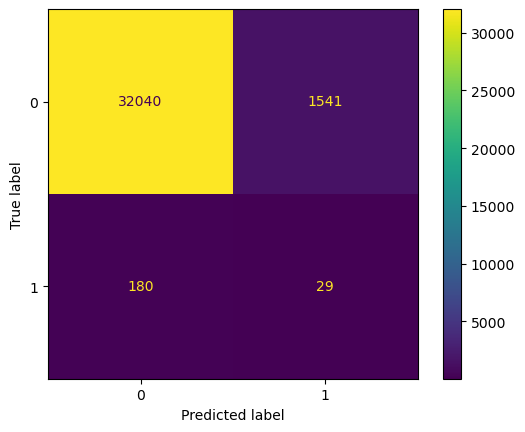

In [26]:
xgb = XGBClassifier(eval_metric="logloss", random_state=42, n_jobs=-1)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [27]:


param_dist_xgb = {
    "max_depth": randint(3, 12),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 5),
}

halving_search_xgb = HalvingRandomSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    resource="n_estimators",
    min_resources=20, # Tried with 200
    max_resources=200,  # And with 2000
    factor=3,
    cv=2, # Tried with 3 folds - took 180 minutes and had the same end results
    scoring="precision",
    n_jobs=-1,
    verbose=1,
)

halving_search_xgb.fit(X_train, y_train)
print("Best XGB params:", halving_search_xgb.best_params_)
print("Chosen n_estimators:", halving_search_xgb.best_estimator_.n_estimators)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 20
max_resources_: 200
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 20
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 4
n_resources: 60
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 2
n_candidates: 2
n_resources: 180
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best XGB params: {'colsample_bytree': np.float64(0.6583342761817025), 'gamma': np.float64(4.0267530483116305), 'learning_rate': np.float64(0.04269107198739058), 'max_depth': 10, 'subsample': np.float64(0.90636472294229), 'n_estimators': 180}
Chosen n_estimators: 180


In [28]:
best_params = halving_search_xgb.best_params_

best_xgb = XGBClassifier(**best_params, random_state=42, n_jobs=-1, bootstrap=True)

best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Length of y_pred:", len(y_pred))
print("Accuracy:", accuracy)

y_scores = best_xgb.predict_proba(X_test)[:, 1]

print(best_params)


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:36:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "bootstrap" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Length of y_pred: 33790
Accuracy: 0.972802604320805
{'colsample_bytree': np.float64(0.6583342761817025), 'gamma': np.float64(4.0267530483116305), 'learning_rate': np.float64(0.04269107198739058), 'max_depth': 10, 'subsample': np.float64(0.90636472294229), 'n_estimators': 180}


Accuracy: 0.972802604320805
Precision: 0.03289473684210526
Recall: 0.11961722488038277


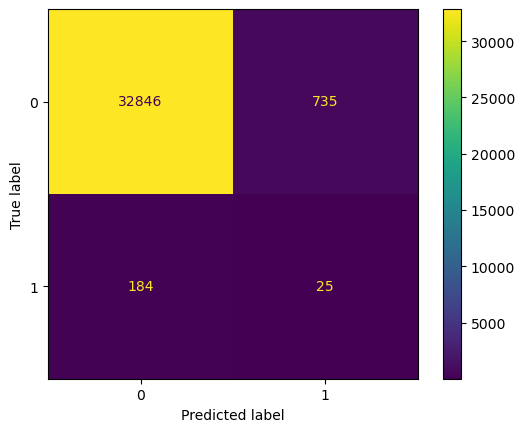

In [29]:
feature_importances = pd.Series(
    best_xgb.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Feature importances:
 maj_landcover_code_y     0.190318
previous_month_rain      0.184144
two_months_prior_rain    0.169443
current_month_rain       0.164507
maj_landcover_code_x     0.147998
dtype: float32


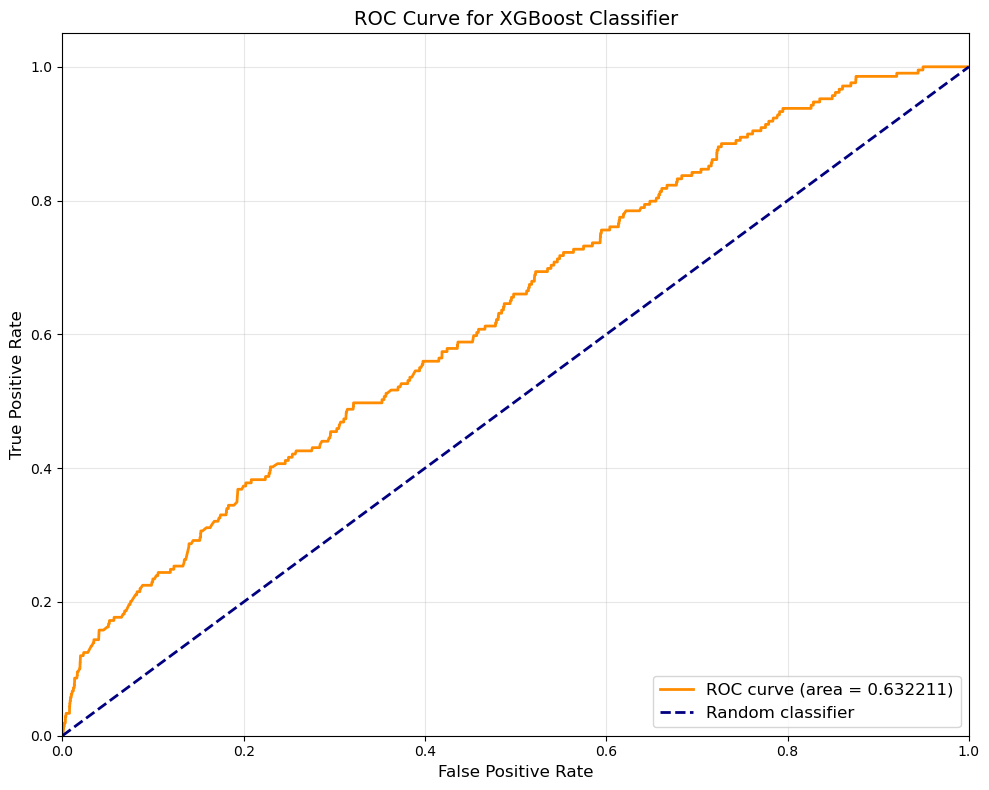

ROC AUC Score: 0.6322


In [30]:
import matplotlib.pyplot as plt

print(f"Feature importances:\n", feature_importances.head())

# Generate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot ROC curve
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.6f})")

# Plot baseline
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random classifier")

# Style the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("ROC Curve for XGBoost Classifier", fontsize=14)
plt.legend(loc="lower right", fontsize=12)

# Add grid
plt.grid(alpha=0.3)

# Display the plot
plt.tight_layout()
plt.show()

# Print numeric results for reference
print(f"ROC AUC Score: {roc_auc:.4f}")
